In [11]:
using Unitful: m, Length, N, inch,@u_str,lbf, lb,s, ustrip, psi,uconvert, ft
using CSV
using DataFrames
using DSP
using GR

# Bar Info
normal info for compression


In [10]:
bar_diameter=.75u"inch"|>u"m"
bar_radius=bar_diameter/2
poisson_ratio=.33
youngs_modulus=29*(10^6)u"psi"|>u"Pa"
bar_density= .284u"lb/inch^3"|>u"kg/m^3"
transmitted_strain_gauge_distance=36u"inch"|>u"m"
incident_strain_gauge_distance=24u"inch"|>u"m"
yeild_strength=50800u"psi"|>u"Pa"

3.502536704929527e8 Pa

# Shot info

In [66]:
length_of_striker = 6u"inch"|>u"m"
speed_of_striker = 40u"ft/s"|>u"m/s"
incident_strain_gauge_distance = 30u"inch"|>u"m"


function wave_speed(youngs,density)
    ((youngs|>u"kg*m/s^2/m^2")/density)^.5
end
function expected_strain_pulse(speed, wave_speed_bar)
    speed/wave_speed_bar/2
end
function duration_pulse(length_of_striker,wave_speed_bar)
    2*length_of_striker/wave_speed_bar
end
wave_speed_bar = wave_speed(youngs_modulus,bar_density)
expected_strain = expected_strain_pulse(speed_of_striker, wave_speed_bar)
pulse_time = duration_pulse(length_of_striker, wave_speed_bar)
lead_in=map(time->0.0,0u"s":1u"μs":0.0001u"s")
incident_pulse=map(time->ustrip(expected_strain),0u"s":1u"μs":pulse_time)
gap=map(time->0.0,0u"s":1u"μs":(incident_strain_gauge_distance/wave_speed_bar))
#quick little filter so it doesn't look dumb
proto=Butterworth(1)
zpk = digitalfilter(Lowpass(0.02), proto)
tf = convert(PolynomialRatio, zpk)
measure_time=map(time->ustrip(time),0u"s":1u"μs":(2u"μs"+pulse_time+2*(incident_strain_gauge_distance/wave_speed_bar)))

incident_bar_strain_history = filt(tf,cat(dims=1,gap,incident_pulse,gap))
max_strain = maximum(incident_bar_strain_history)

0.0011817761296526285

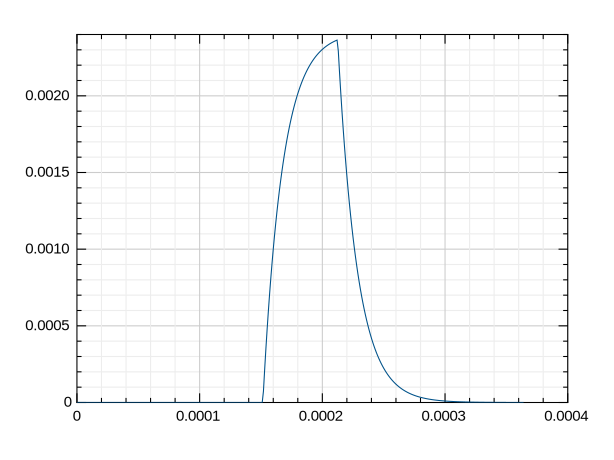

In [36]:
GR.setviewport(0.1, 0.95, 0.1, 0.95)
GR.setwindow(-2, 2, -2, 2)
GR.setspace(-0.5, 0.5, 0, 90)
GR.setmarkersize(1)
GR.setmarkertype(-1)
GR.setcharheight(0.024)
GR.settextalign(2, 0)
GR.settextfontprec(3, 0)


plot(measure_time,incident_bar_strain_history)


# Sample Info
sample is a cylinder with the round ends touching the bar ends

In [43]:
diameter_sample = .5u"inch"|>u"m"
thickness_sample = .5u"inch"|>u"m"
sample_strength = 19u"MPa"
#only equation to implement
function stress_sample(force,diameter,thickness)
    (2/π*force/(diameter*thickness))|>u"MPa"
end

stress_sample (generic function with 1 method)

In [55]:
max_transmitted_strain=(sample_strength|>u"N/m^2")*diameter_sample*thickness_sample*π/2/((youngs_modulus|>u"N/m^2")*bar_radius^2*π)
percent_transmitted = max_transmitted_strain/max_strain

0.07147413105896525

In [72]:
transmitted_strain_lead = map(val->0, incident_bar_strain_history)
transmitted_data = map(val->-val*percent_transmitted, incident_bar_strain_history)
transmitted_bar_strain_history = cat(dims=1,transmitted_strain_lead , transmitted_data)
reflected_pulse = map(val->val*(1-percent_transmitted), incident_bar_strain_history)
full_incident_bar_strain_history= cat(dims=1, -incident_bar_strain_history,reflected_pulse )
full_measure_time=map(time->ustrip(time),0u"s":1u"μs":(4u"μs"+pulse_time*2+4*(incident_strain_gauge_distance/wave_speed_bar)));


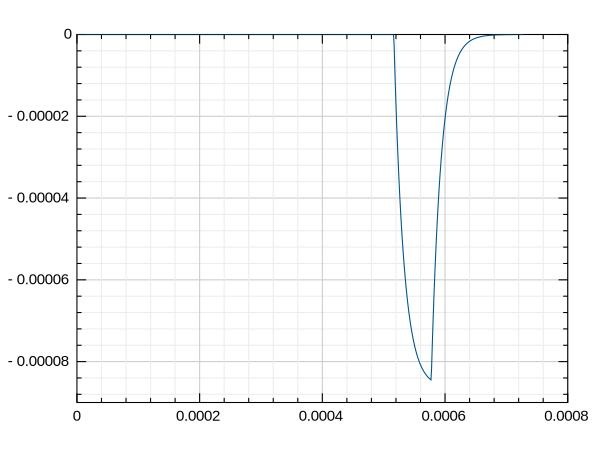

In [70]:
GR.setviewport(0.1, 0.95, 0.1, 0.95)
GR.setwindow(-2, 2, -2, 2)
GR.setspace(-0.5, 0.5, 0, 90)
GR.setmarkersize(1)
GR.setmarkertype(-1)
GR.setcharheight(0.024)
GR.settextalign(2, 0)
GR.settextfontprec(3, 0)


plot(full_measure_time,full_incident_bar_strain_history)


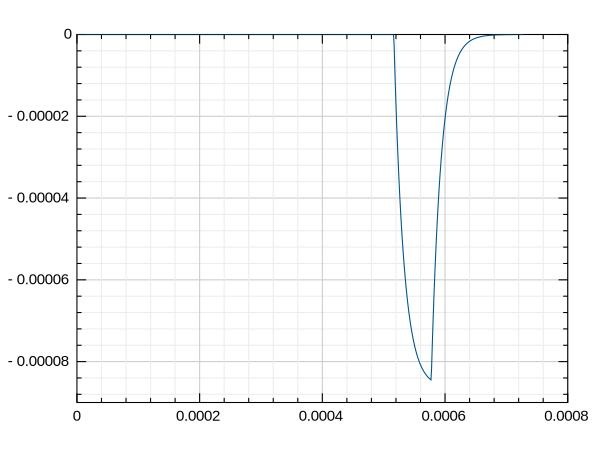

In [71]:
plot(full_measure_time,transmitted_bar_strain_history)


In [74]:
data_frame=DataFrame(time_seconds=full_measure_time,incident_strain_gauge=full_incident_bar_strain_history,transmitted_strain_gauge=transmitted_bar_strain_history)
CSV.write("example_data.csv",data_frame)

"example_data.csv"

# Calculation discussions
All strain results must come from either DIC or direct sample measurement with a strain gauge. Without that all that can be gathered is a stress pulse.

If there is no strain data, just display force vs time.

Displacement can be assumed to be relative to radius. (strain\*radius=displacement) This is made up by me. I'll let you know if this improves.

There is only one equation to implement, that being the ```sample_stress``` function.